<a href="https://colab.research.google.com/github/zoebatz/EEL6878/blob/main/graphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import random

In [4]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.utils import from_networkx

In [5]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import remove_isolated_nodes, train_test_split_edges
import torch.nn.functional as F
from torch_geometric.data import Data

In [6]:
# load data

df_ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_project/ml-100k/ratings.csv')
df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_project/ml-100k/movies.csv')
df_ratings = df_ratings.drop('timestamp', axis=1)
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
df = df_ratings.merge(df_movies, on='movieId')
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [8]:
# Map userIds and movieIds to consecutive node indices
user_mapping = {id: idx for idx, id in enumerate(df['userId'].unique())}
movie_mapping = {id: idx + len(user_mapping) for idx, id in enumerate(df['movieId'].unique())}

# Create edge list
edge_index = []
edge_weight = []

for _, row in df.iterrows():
    u = user_mapping[row['userId']]
    m = movie_mapping[row['movieId']]
    edge_index.append([u, m])
    edge_index.append([m, u])  # Make it undirected
    edge_weight.append(row['rating'])
    edge_weight.append(row['rating'])  # Same rating back

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create Graph
G = Data(edge_index=edge_index, edge_attr=edge_weight)

# Set total number of nodes
G.num_nodes = len(user_mapping) + len(movie_mapping)

print(G)


Data(edge_index=[2, 201672], edge_attr=[201672], num_nodes=10334)


In [9]:
transform = RandomLinkSplit(
    is_undirected=True,
    split_labels=True,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0,  # 1:1 ratio
)

train_data, val_data, test_data = transform(G)

print(train_data)


Data(edge_index=[2, 141172], edge_attr=[141172], num_nodes=10334, pos_edge_label=[70586], pos_edge_label_index=[2, 70586], neg_edge_label=[70586], neg_edge_label_index=[2, 70586])


In [10]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [11]:
# Random node features
x = torch.randn((G.num_nodes, 64))  # 64-dim features

In [12]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def evaluate(model, x, data):
    model.eval()

    z = model(x, data.edge_index)

    pos_edge = data.pos_edge_label_index
    neg_edge = data.neg_edge_label_index

    # Positive and Negative Scores
    pos_score = (z[pos_edge[0]] * z[pos_edge[1]]).sum(dim=1)
    neg_score = (z[neg_edge[0]] * z[neg_edge[1]]).sum(dim=1)

    # Stack all predictions and labels
    y_pred = torch.cat([pos_score, neg_score])
    y_true = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))]).to(y_pred.device)

    # Use sigmoid because logits are raw scores
    auc = roc_auc_score(y_true.cpu(), y_pred.cpu().sigmoid())

    return auc


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNNEncoder(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x = x.to(device)
train_data = train_data.to(device)
val_data = val_data.to(device)

loss_list = []
train_auc_list = []
val_auc_list = []

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()

    # Encode nodes
    z = model(x, train_data.edge_index)

    # Positive and negative samples
    pos_edge = train_data.pos_edge_label_index
    neg_edge = train_data.neg_edge_label_index

    # Positive score
    pos_score = (z[pos_edge[0]] * z[pos_edge[1]]).sum(dim=1)
    neg_score = (z[neg_edge[0]] * z[neg_edge[1]]).sum(dim=1)

    # Loss: maximize pos_score, minimize neg_score
    loss = F.binary_cross_entropy_with_logits(
        torch.cat([pos_score, neg_score]),
        torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))]).to(device)
    )

    loss.backward()
    optimizer.step()


    train_auc = evaluate(model, x, train_data)
    val_auc = evaluate(model, x, val_data)

    loss_list.append(loss.item())
    train_auc_list.append(train_auc)
    val_auc_list.append(val_auc)

    if epoch % 10 == 0:
      print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")

     # print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 010, Loss: 0.6750, Train AUC: 0.7644, Val AUC: 0.7328
Epoch 020, Loss: 0.5992, Train AUC: 0.8759, Val AUC: 0.8465
Epoch 030, Loss: 0.5288, Train AUC: 0.9035, Val AUC: 0.8694
Epoch 040, Loss: 0.4879, Train AUC: 0.9278, Val AUC: 0.8820
Epoch 050, Loss: 0.4663, Train AUC: 0.9448, Val AUC: 0.8873
Epoch 060, Loss: 0.4509, Train AUC: 0.9575, Val AUC: 0.8871
Epoch 070, Loss: 0.4388, Train AUC: 0.9656, Val AUC: 0.8870
Epoch 080, Loss: 0.4294, Train AUC: 0.9712, Val AUC: 0.8870
Epoch 090, Loss: 0.4215, Train AUC: 0.9749, Val AUC: 0.8863
Epoch 100, Loss: 0.4147, Train AUC: 0.9777, Val AUC: 0.8854


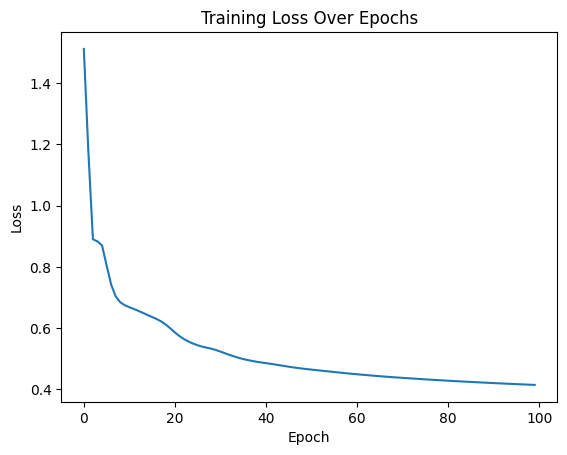

In [30]:
# graph loss
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

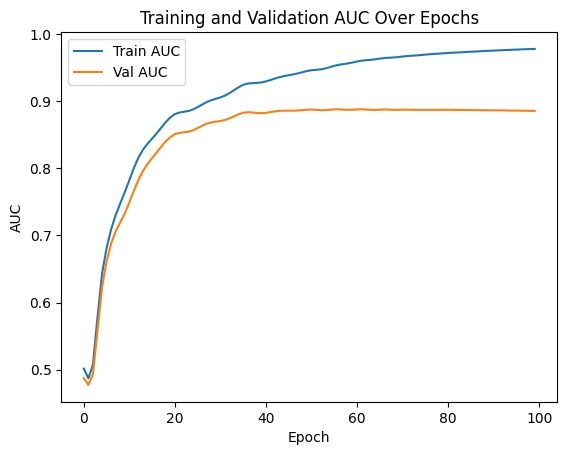

In [31]:
# graph training and eval AUC
plt.plot(train_auc_list, label='Train AUC')
plt.plot(val_auc_list, label='Val AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC Over Epochs')
plt.show()

In [32]:
# use trained model to make predictions

# get all node embeddings
G.to(device)
model.eval()
with torch.no_grad():
  z = model(x, G.edge_index)

In [33]:
'''num_users = len(user_mapping)
num_movies = len(movie_mapping)

user_embeddings = z[:num_users]
movie_embeddings = z[num_users:]
'''

'num_users = len(user_mapping)\nnum_movies = len(movie_mapping)\n\nuser_embeddings = z[:num_users]\nmovie_embeddings = z[num_users:]\n'

In [34]:
num_users = len(user_mapping)

user_emb = z[:num_users]
movie_emb = z[num_users:]

# batch users to find recommendations for
user_ids = [100, 200, 300]

internal_user_ids = [user_mapping[u] for u in user_ids]

batch_user_emb = user_emb[internal_user_ids]

# compute similarity score
scores = batch_user_emb @ movie_emb.T

user_to_seen_movies = {u: set(df[df['userId'] == u]['movieId']) for u in user_ids}

# mask movies each user has already seen
mask = torch.zeros_like(scores, dtype=torch.bool)

for i, user_id in enumerate(user_ids):
  seen_movies = user_to_seen_movies.get(user_id, set())
  internal_seen = [movie_mapping[movieId] - num_users for movieId in seen_movies]
  mask[i, internal_seen] = True

scores[mask] = -float('inf')

In [35]:
top_k = 10

# get top k for each user
top_k_scores, top_k_indices = scores.topk(top_k, dim=1)

inv_movie_mapping = {v: k for k, v in movie_mapping.items()}

# recs for each user in batch
recommendations = []
for indices in top_k_indices:
  recommended_movieIds = [inv_movie_mapping[index.item() + num_users] for index in indices]
  recommendations.append(recommended_movieIds)

In [36]:
# easy title look up
movieId_to_title = dict(zip(df_movies['movieId'], df_movies['title']))


In [37]:
# display top k recommendations for each user in batch
for i, (user_id, rec_movieIds) in enumerate(zip(user_ids, recommendations)):
    print(f"\nUser {user_id} Recommendations:")
    for j, movieId in enumerate(rec_movieIds):
        title = movieId_to_title.get(movieId, "Unknown Title")
        score = top_k_scores[i, j].item()
        print(f"  {movieId}: {title} (score: {score:.4f})")


User 100 Recommendations:
  180231: Daddy's Home 2 (2017) (score: 4.9526)
  5418: Bourne Identity, The (2002) (score: 4.8138)
  552: Three Musketeers, The (1993) (score: 4.5355)
  349: Clear and Present Danger (1994) (score: 4.5225)
  480: Jurassic Park (1993) (score: 4.4615)
  1: Toy Story (1995) (score: 4.4574)
  300: Quiz Show (1994) (score: 4.4451)
  2571: Matrix, The (1999) (score: 4.4231)
  589: Terminator 2: Judgment Day (1991) (score: 4.4054)
  318: Shawshank Redemption, The (1994) (score: 4.3811)

User 200 Recommendations:
  410: Addams Family Values (1993) (score: 4.9390)
  527: Schindler's List (1993) (score: 4.8862)
  160: Congo (1995) (score: 4.8312)
  231: Dumb & Dumber (Dumb and Dumber) (1994) (score: 4.7101)
  589: Terminator 2: Judgment Day (1991) (score: 4.6673)
  364: Lion King, The (1994) (score: 4.5336)
  1584: Contact (1997) (score: 4.5136)
  185: Net, The (1995) (score: 4.4859)
  457: Fugitive, The (1993) (score: 4.4787)
  96606: Samsara (2011) (score: 4.4656)



In [27]:
grouped = df.groupby('userId')

# Only process users in the batch
for user_id in user_ids:
    if user_id in grouped.groups:
        group = grouped.get_group(user_id)

        max_rating = group['rating'].max()
        top_movies = group[group['rating'] == max_rating]

        print(f"\nUser {user_id}'s Top Rated Movies (Rating {max_rating}):")

        for _, row in top_movies.iterrows():
            print(f"  {row['movieId']}: {row['title']}")
    else:
        print(f"\nUser {user_id} has no ratings.")


User 100's Top Rated Movies (Rating 5.0):
  1101: Top Gun (1986)
  1958: Terms of Endearment (1983)
  2423: Christmas Vacation (National Lampoon's Christmas Vacation) (1989)
  4041: Officer and a Gentleman, An (1982)
  5620: Sweet Home Alabama (2002)

User 200's Top Rated Movies (Rating 5.0):
  39: Clueless (1995)
  260: Star Wars: Episode IV - A New Hope (1977)
  296: Pulp Fiction (1994)
  318: Shawshank Redemption, The (1994)
  441: Dazed and Confused (1993)
  597: Pretty Woman (1990)
  1020: Cool Runnings (1993)
  1042: That Thing You Do! (1996)
  1196: Star Wars: Episode V - The Empire Strikes Back (1980)
  1197: Princess Bride, The (1987)
  1210: Star Wars: Episode VI - Return of the Jedi (1983)
  1380: Grease (1978)
  1500: Grosse Pointe Blank (1997)
  1777: Wedding Singer, The (1998)
  2144: Sixteen Candles (1984)
  2396: Shakespeare in Love (1998)
  2571: Matrix, The (1999)
  2572: 10 Things I Hate About You (1999)
  2918: Ferris Bueller's Day Off (1986)
  2959: Fight Club (19